In [92]:
import sys
! pip install kaggle seaborn pandas numpy matplotlib
!{sys.executable} -m pip install kaggle seaborn pandas numpy matplotlib

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("customer_shopping_data.csv")


# TRANSFORMACION DE DATOS
Convertiremos los datos en dimensiones que podremos utilizar facilmente

In [94]:
import string
def convertirIndice(idxString):
    lista_letras = list(string.ascii_lowercase)
    idxString = str(idxString)
    nuevo_idx = ""
    for char in idxString:
        if char.lower() in lista_letras:
            nuevo_idx += str(lista_letras.index(char.lower()))
        else:
            nuevo_idx += char
    return int(nuevo_idx)

In [95]:
df['customer_id'] = [convertirIndice(x) for x in df['customer_id']]
df['invoice_no'] = [convertirIndice(x) for x in df['invoice_no']]
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,8138884,2241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,8317333,2111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,8127801,2266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,8173702,2988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,8337046,2189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [96]:
# Crear la tabla DimCliente
DimCliente = df[['customer_id', 'gender', 'age']].drop_duplicates().reset_index(drop=True)
DimCliente.rename(columns={'customer_id': 'IDCliente', 'gender': 'Genero', 'age': 'Edad'}, inplace=True)
DimCliente.head()


,IDCliente,Genero,Edad
0,2241288,Female,28
1,2111565,Male,21
2,2266599,Male,20
3,2988172,Female,66
4,2189076,Female,53


In [97]:
# Crear la tabla DimProducto
DimProducto = df[['category']].drop_duplicates().reset_index(drop=True)
DimProducto['IDProducto'] = DimProducto.index + 1
DimProducto.rename(columns={'category': 'Categoria'}, inplace=True)

DimProducto.head()

,Categoria,IDProducto
0,Clothing,1
1,Shoes,2
2,Books,3
3,Cosmetics,4
4,Food & Beverage,5


In [98]:
# Crear la tabla DimFecha
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True, errors='coerce')
DimFecha = df[['invoice_date']].drop_duplicates().reset_index(drop=True)
DimFecha['IDFecha'] = DimFecha.index + 1
DimFecha['Año'] = DimFecha['invoice_date'].dt.year
DimFecha['Mes'] = DimFecha['invoice_date'].dt.month
DimFecha['DiaSemana'] = DimFecha['invoice_date'].dt.day_name()
DimFecha.rename(columns={'invoice_date': 'FechaFactura'}, inplace=True)

#DimFecha.sort_values(['Año', 'Mes', 'DiaSemana'])
DimFecha.head()

,FechaFactura,IDFecha,Año,Mes,DiaSemana
0,2022-08-05,1,2022,8,Friday
1,2021-12-12,2,2021,12,Sunday
2,2021-11-09,3,2021,11,Tuesday
3,2021-05-16,4,2021,5,Sunday
4,2021-10-24,5,2021,10,Sunday


In [99]:
# Crear la tabla DimTienda
DimTienda = df[['shopping_mall']].drop_duplicates().reset_index(drop=True)
DimTienda['IDTienda'] = DimTienda.index + 1
DimTienda.rename(columns={'shopping_mall': 'CentroComercial'}, inplace=True)
DimTienda.head()

,CentroComercial,IDTienda
0,Kanyon,1
1,Forum Istanbul,2
2,Metrocity,3
3,Metropol AVM,4
4,Istinye Park,5


In [100]:
# Fusionar con cada tabla de dimensiones
Ventas = df.merge(DimCliente, left_on='customer_id', right_on='IDCliente')\
           .merge(DimProducto, left_on='category', right_on='Categoria')\
           .merge(DimFecha, left_on='invoice_date', right_on='FechaFactura')\
           .merge(DimTienda, left_on='shopping_mall', right_on='CentroComercial')

# Seleccionar solo las columnas necesarias
Ventas = Ventas[['invoice_no', 'IDCliente', 'IDProducto', 'IDFecha', 'IDTienda', 'quantity', 'price', 'payment_method']]
Ventas.rename(columns={'invoice_no': 'NumFacturaNominal', 'quantity': 'Cantidad', 'price': 'Precio', 'payment_method': 'MetodoPago'}, inplace=True)
Ventas.head()

,NumFacturaNominal,IDCliente,IDProducto,IDFecha,IDTienda,Cantidad,Precio,MetodoPago
0,8138884,2241288,1,1,1,5,1500.40,Credit Card
1,8317333,2111565,2,2,2,3,1800.51,Debit Card
2,8127801,2266599,1,3,3,1,300.08,Cash
3,8173702,2988172,2,4,4,5,3000.85,Credit Card
4,8337046,2189076,3,5,1,4,60.60,Cash


# Gráficas del Dataset
Empezamos a visualizar los datos

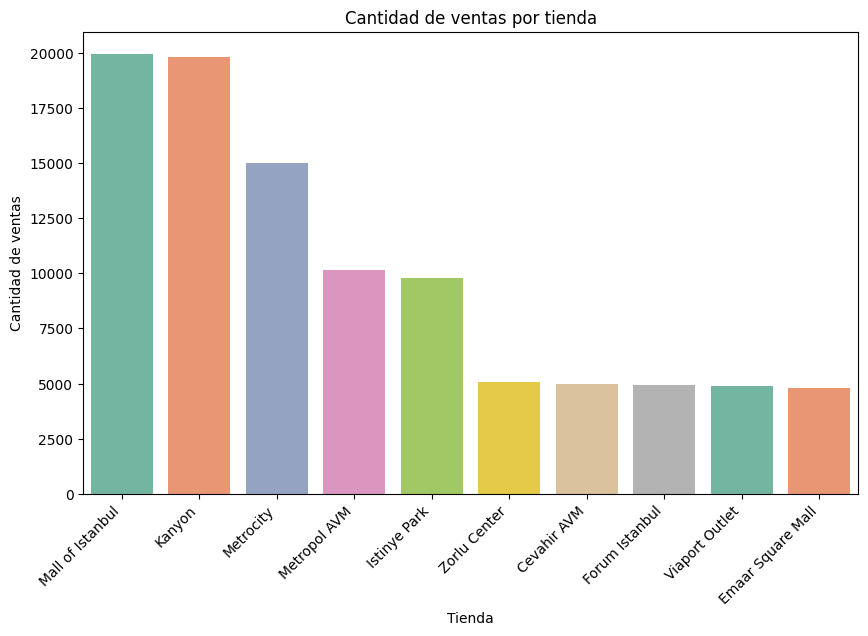

,CentroComercial,Cantidad,Ingreso_Bruto
5,Mall of Istanbul,19943,50872481.68
4,Kanyon,19823,50554231.10
6,Metrocity,15011,37302787.33
7,Metropol AVM,10161,25379913.19
3,Istinye Park,9781,24618827.68
9,Zorlu Center,5075,12901053.82
0,Cevahir AVM,4991,12645138.20
2,Forum Istanbul,4947,12303921.24
8,Viaport Outlet,4914,12521339.72
1,Emaar Square Mall,4811,12406100.29


In [101]:
#----------------CANTIDAD DE VENTAS POR TIENDA----------------
ventas_temp = Ventas.merge(DimTienda, left_on='IDTienda', right_on='IDTienda')
ventasTienda = ventas_temp.groupby('CentroComercial').size().reset_index(name='Cantidad')
ventas_temp['Ingreso_Bruto'] = ventas_temp['Cantidad'] * ventas_temp['Precio'] #DATAFRAME CON INGRESO BRUTO POR TIENDA
ventasTienda["Ingreso_Bruto"] = ventas_temp.groupby('CentroComercial')['Ingreso_Bruto'].sum().values

ventasTienda.sort_values('Cantidad', ascending=False, inplace=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='CentroComercial', y= 'Cantidad', palette='Set2', data=ventasTienda, hue='CentroComercial')

plt.title('Cantidad de ventas por tienda') 
plt.xlabel('Tienda')
plt.ylabel('Cantidad de ventas')
plt.xticks(rotation=45, ha='right')
plt.show()

ventasTienda




J:\TempKobold\ipykernel_4188\2523465355.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DiaSemana', y='Ingreso_Bruto', data=ventas_por_dia_semana, palette='Set2')


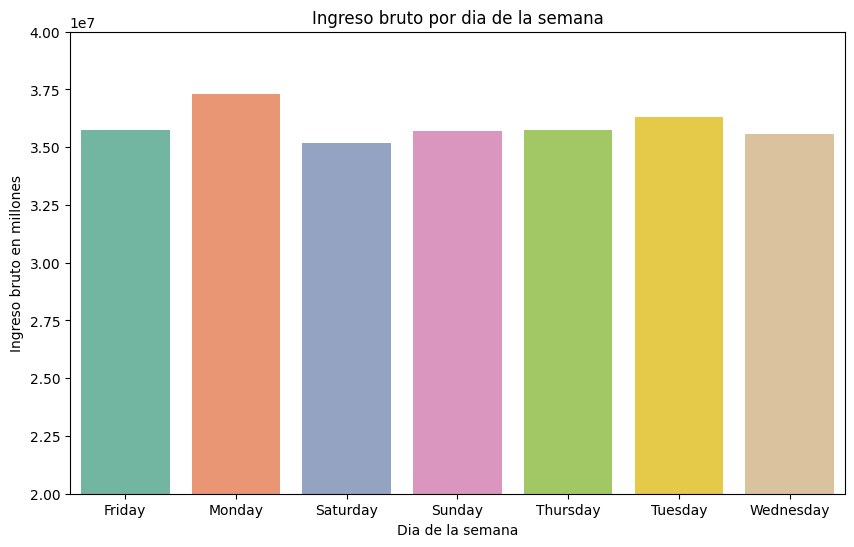

,DiaSemana,Ingreso_Bruto
0,Friday,35728331.39
1,Monday,37296648.11
2,Saturday,35179828.72
3,Sunday,35689090.61
4,Thursday,35738148.63
5,Tuesday,36298096.66
6,Wednesday,35575650.13


In [102]:
#----------------INGRESO BRUTO POR DIA----------------
ventas_por_dia_semana = Ventas.merge(DimFecha, left_on='IDFecha', right_on='IDFecha')
ventas_por_dia_semana['Ingreso_Bruto'] = ventas_por_dia_semana['Cantidad'] * ventas_por_dia_semana['Precio']
ventas_por_dia_semana = ventas_por_dia_semana[['DiaSemana', 'Ingreso_Bruto', 'Precio', 'Cantidad']]
ventas_por_dia_semana = ventas_por_dia_semana.groupby('DiaSemana')['Ingreso_Bruto'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='DiaSemana', y='Ingreso_Bruto', data=ventas_por_dia_semana, palette='Set2')
plt.ylim(20000000, 40000000)
plt.title('Ingreso bruto por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Ingreso bruto en millones')
plt.show()
ventas_por_dia_semana

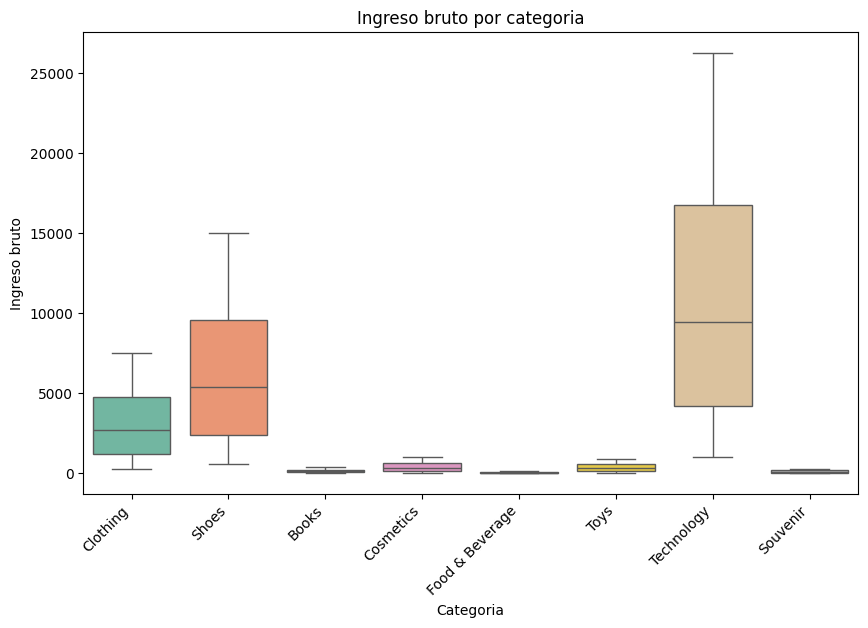

,Cantidad,Precio,Categoria,ingreso_bruto
0,5,1500.40,Clothing,7502.00
1,3,1800.51,Shoes,5401.53
2,1,300.08,Clothing,300.08
3,5,3000.85,Shoes,15004.25
4,4,60.60,Books,242.40
...,...,...,...,...
99452,5,58.65,Souvenir,293.25
99453,2,10.46,Food & Beverage,20.92
99454,2,10.46,Food & Beverage,20.92
99455,4,4200.00,Technology,16800.00


In [ ]:
#----------------Ventas por Categorias y genero----------------
ventas_categorias = Ventas.merge(DimProducto, left_on='IDProducto', right_on='IDProducto')
ventas_categorias['ingreso_bruto'] = ventas_categorias['Cantidad'] * ventas_categorias['Precio']
ventas_categorias =ventas_categorias[['Cantidad', 'Precio', 'Categoria', 'ingreso_bruto']]
#ventas_categorias.groupby('Categoria')['ingreso_bruto' ].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria', y='ingreso_bruto', data=ventas_categorias, hue='Categoria', palette='Set2')
plt.title('Ingreso bruto por categoria')
plt.xlabel('Categoria')
plt.ylabel('Ingreso bruto')
plt.xticks(rotation=45, ha='right')
plt.show()

ventas_categorias



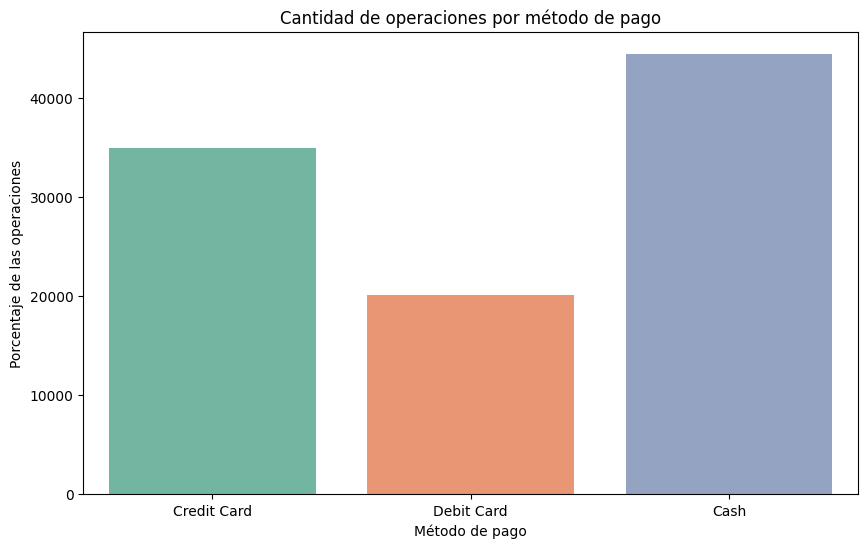

MetodoPago
Cash           44447
Credit Card    34931
Debit Card     20079
dtype: int64

In [11]:
#------------CANTIDAD DE OPERACIONES SEGUN EL METODO DE PAGO----------------
ventasAgrupadas = Ventas.groupby('MetodoPago')

plt.figure(figsize=(10, 6))
sns.countplot(x='MetodoPago', data=Ventas, hue='MetodoPago', palette='Set2', stat='count', width=0.8)
plt.title('Cantidad de operaciones por método de pago')
plt.xlabel('Método de pago')
plt.ylabel('Porcentaje de las operaciones')
plt.show()

ventasAgrupadas.size()